# Task 1

In [1]:
from tensorflow.python.ops.gen_data_flow_ops import BarrierTakeMany
import cv2
import numpy as np
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

FRAME_SIZE = (112, 112)

def resize_image(img):
  global FRAME_SIZE
  h, w = img.shape[:2]
  c = img.shape[2] if len(img.shape)>2 else 1
  if h == w: 
      return cv2.resize(img, FRAME_SIZE, cv2.INTER_AREA)
  dif = h if h > w else w
  interpolation = cv2.INTER_AREA if dif > (FRAME_SIZE[0]+FRAME_SIZE[1])//2 else cv2.INTER_CUBIC
  x_pos = (dif - w)//2
  y_pos = (dif - h)//2
  if len(img.shape) == 2:
      mask = np.zeros((dif, dif), dtype=img.dtype)
      mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
  else:
      mask = np.zeros((dif, dif, c), dtype=img.dtype)
      mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]
  return cv2.resize(mask, FRAME_SIZE, interpolation)


def get_trained_model(X, Y, model_builder, fine_tune=True, epochs=25):
  model = model_builder()
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  model.fit(X, tf.keras.utils.to_categorical(Y, 12), batch_size=128, epochs=epochs)

  if fine_tune:
    for i in range(len(model.layers)):
      if model.layers[i].name in ["batch_" + str(i) for i in range(1, 3)]:
        model.layers[i].trainable = False
      else:
        model.layers[i].trainable = True

    model.compile(loss="categorical_crossentropy", 
                  optimizer=tf.optimizers.Adam(learning_rate=1e-5), metrics=["accuracy"])
    model.fit(X, tf.keras.utils.to_categorical(Y, 12), batch_size=128, epochs=epochs)

    for i in range(len(model.layers)):
        model.layers[i].trainable = True

  return model

def evaluate_model(X, Y, model):
  score = model.evaluate(X, tf.keras.utils.to_categorical(Y, 12), batch_size=128, verbose=0)
  eval_metrics = {metric: score[idx] for idx, metric in enumerate(model.metrics_names)}
  return eval_metrics

def multi_input_kfold_cv(X, Y, model_builder, epochs=25, splits=5):
  skf = StratifiedKFold(n_splits=splits, shuffle=True)

  loss = np.zeros(epochs, dtype=np.float32)
  accuracy = np.zeros(epochs, dtype=np.float32)
  val_loss = np.zeros(epochs, dtype=np.float32)
  val_accuracy = np.zeros(epochs, dtype=np.float32)

  for fold_index, (train_idxs, val_idxs) in enumerate(skf.split(X[0], Y)):
    x_train_fold_1, x_val_fold_1 = X[0][train_idxs], X[0][val_idxs]
    x_train_fold_2, x_val_fold_2 = X[1][train_idxs], X[1][val_idxs]
    y_train_fold, y_val_fold = Y[train_idxs], Y[val_idxs]

    model = model_builder()
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    history = model.fit([x_train_fold_1, x_train_fold_2], tf.keras.utils.to_categorical(y_train_fold, 12),
                        validation_data=([x_val_fold_1, x_val_fold_2], tf.keras.utils.to_categorical(y_val_fold, 12)),
                        batch_size=128, epochs=epochs)
    
    for i in range(epochs):
      loss[i] += history.history["loss"][i]
      accuracy[i] += history.history["accuracy"][i]
      val_loss[i] += history.history["val_loss"][i]
      val_accuracy[i] += history.history["val_accuracy"][i]
  
  loss /= splits
  accuracy /= splits
  val_loss /= splits
  val_accuracy /= splits

  perf_metrics = {"loss": loss, "accuracy": accuracy, 
                  "val_loss": val_loss, "val_accuracy": val_accuracy}

  return perf_metrics


def kfold_cv(X, Y, model_builder, epochs=25, splits=5):
  skf = StratifiedKFold(n_splits=splits, shuffle=True)

  print(f"{splits}-Folds Stratified Cross-Validation started")

  loss = np.zeros(epochs, dtype=np.float32)
  accuracy = np.zeros(epochs, dtype=np.float32)
  val_loss = np.zeros(epochs, dtype=np.float32)
  val_accuracy = np.zeros(epochs, dtype=np.float32)

  for fold_index, (train_idxs, val_idxs) in enumerate(skf.split(X, Y)):
    x_train_fold, x_val_fold = X[train_idxs], X[val_idxs]
    y_train_fold, y_val_fold = Y[train_idxs], Y[val_idxs]

    model = model_builder()
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    history = model.fit(x_train_fold, tf.keras.utils.to_categorical(y_train_fold, 12),
                        validation_data=(x_val_fold, tf.keras.utils.to_categorical(y_val_fold, 12)),
                        batch_size=128, epochs=epochs)
    
    for i in range(epochs):
      loss[i] += history.history["loss"][i]
      accuracy[i] += history.history["accuracy"][i]
      val_loss[i] += history.history["val_loss"][i]
      val_accuracy[i] += history.history["val_accuracy"][i]
  
  loss /= splits
  accuracy /= splits
  val_loss /= splits
  val_accuracy /= splits

  perf_metrics = {"loss": loss, "accuracy": accuracy, 
                  "val_loss": val_loss, "val_accuracy": val_accuracy}

  return perf_metrics

def serialize_model(model, name=None):
  Path("Models").mkdir(parents=True, exist_ok=True)
  model.save(os.path.join("Models", model.name if name is None else name), overwrite=True)

def plot_conf_matrix(X, Y, model, classes, norm=False):
  Y_pred = model.predict(X, verbose=0)
  Y_pred_labels = np.argmax(Y_pred, axis=1)
  conf_matrix = confusion_matrix(Y, Y_pred_labels)
  if norm:
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
  fig, ax = plt.subplots(figsize=(14,14))
  disp.plot(ax=ax)

def plot_train_val_metrics(metrics, model_name):
  figure, axis = plt.subplots(1, 2)
  for plot_idx, metric in enumerate(["loss", "accuracy"]):
    tl, vl = metrics[metric], metrics["val_" + metric]
    ax = axis[plot_idx]
    ax.plot(tl)
    ax.plot(vl)
    ax.set_title(model_name)
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel('epoch')
    ax.legend(['train', 'val'], loc='upper left')

  figure.set_figwidth(7)
  figure.tight_layout()
  plt.show()

def get_frames_from_index(video, start_index, count=1, resize=True):
  global FRAME_SIZE

  video_width  = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
  video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

  np_shape =  (count, FRAME_SIZE[0], FRAME_SIZE[1], 3) if resize else \
              (count, video_height, video_width, 3)

  frames = np.zeros(shape=np_shape, dtype=np.float32)
  frame_curr_index = 0

  while video.isOpened():
    ret, frame = video.read()
    if ret:
      if frame_curr_index >= start_index and \
        frame_curr_index < start_index + count:
        idx = frame_curr_index - start_index
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if resize:
          rgb_frame = resize_image(rgb_frame)
        frames[idx] = rgb_frame
      elif frame_curr_index >= start_index:
        break
    else:
      video.release()
      raise Exception("This should never happen! (1)")
      break
    frame_curr_index += 1

  return frames if count > 1 else frames[0]

def compute_optical_flow(video, start_index, samples_count=4):
  frame_curr_index = 0
  
  frames = get_frames_from_index(video, start_index, 1 + samples_count, False)

  optical_flow = []
  prev = cv2.cvtColor(frames[0], cv2.COLOR_RGB2GRAY)
  hsv = np.zeros(frames[0].shape, dtype=np.uint8)
  hsv[..., 1] = 255

  for i in range(1, 1 + samples_count):
    next = cv2.cvtColor(frames[i], cv2.COLOR_RGB2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    prev = next
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb_opt_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    rgb_opt_flow = resize_image(rgb_opt_flow)
    optical_flow.append(rgb_opt_flow)

  return np.array(optical_flow, dtype=np.float32)

def shuffle_dataset(X, Y):
    p = np.random.permutation(X.shape[0])
    return X[p], Y[p]

In [2]:
!rm -r Stanford40/
!rm Stanford40_ImageSplits.zip
!rm Stanford40_JPEGImages.zip

!wget http://vision.stanford.edu/Datasets/Stanford40_JPEGImages.zip
!wget http://vision.stanford.edu/Datasets/Stanford40_ImageSplits.zip

!unzip Stanford40_JPEGImages.zip -d Stanford40/
!unzip Stanford40_ImageSplits.zip -d Stanford40/

Streaming output truncated to the last 5000 lines.
  inflating: Stanford40/JPEGImages/phoning_213.jpg  
  inflating: Stanford40/JPEGImages/phoning_214.jpg  
  inflating: Stanford40/JPEGImages/phoning_215.jpg  
  inflating: Stanford40/JPEGImages/phoning_216.jpg  
  inflating: Stanford40/JPEGImages/phoning_217.jpg  
  inflating: Stanford40/JPEGImages/phoning_218.jpg  
  inflating: Stanford40/JPEGImages/phoning_219.jpg  
  inflating: Stanford40/JPEGImages/phoning_220.jpg  
  inflating: Stanford40/JPEGImages/phoning_221.jpg  
  inflating: Stanford40/JPEGImages/phoning_222.jpg  
  inflating: Stanford40/JPEGImages/phoning_223.jpg  
  inflating: Stanford40/JPEGImages/phoning_224.jpg  
  inflating: Stanford40/JPEGImages/phoning_225.jpg  
  inflating: Stanford40/JPEGImages/phoning_226.jpg  
  inflating: Stanford40/JPEGImages/phoning_227.jpg  
  inflating: Stanford40/JPEGImages/phoning_228.jpg  
  inflating: Stanford40/JPEGImages/phoning_229.jpg  
  inflating: Stanford40/JPEGImages/phoning_230.j

In [3]:
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [4]:
STAN40_CLASSES = ["applauding", "climbing", "drinking", "jumping", 
                  "pouring_liquid", "riding_a_bike", "riding_a_horse", "running", 
                  "shooting_an_arrow", "smoking", "throwing_frisby", "waving_hands"]

def get_stanford40_dataset():
  global STAN40_IMG_PATH, STAN40_SPLIT_PATH, STAN40_CLASSES, FRAME_SIZE

  def fill_data(files):
    X_data = np.zeros((len(files), FRAME_SIZE[0], FRAME_SIZE[1], 3))
    for idx, file in enumerate(files):
      file_img = tf.keras.utils.load_img(
          os.path.join("Stanford40/JPEGImages", file))
      
      file_img = tf.keras.utils.img_to_array(file_img)
      file_img = resize_image(file_img)
      X_data[idx] = file_img

    return X_data

  sample_names = []
  sample_labels = []

  for file in ["train.txt", "test.txt"]:
    with open(os.path.join("Stanford40/ImageSplits", file), 'r') as f:
      for sample_name in list(map(str.strip, f.readlines())):
        class_name = '_'.join(sample_name.split('_')[:-1])
        if class_name in STAN40_CLASSES:
          sample_names.append(sample_name)
          sample_labels.append(STAN40_CLASSES.index(class_name))

  X_train, X_test, Y_train, Y_test = train_test_split(sample_names, sample_labels, test_size=0.1, random_state=0, stratify=sample_labels)

  return fill_data(X_train), fill_data(X_test), np.array(Y_train, dtype=np.int32), np.array(Y_test, dtype=np.int32)

In [5]:
def get_stanford40():
  global FRAME_SIZE
  model = tf.keras.Sequential([
    tf.keras.Input(shape=(FRAME_SIZE[0], FRAME_SIZE[1], 3)),
    tf.keras.layers.Rescaling(1./255),

    tf.keras.layers.RandomFlip(mode="horizontal"),
    tf.keras.layers.RandomBrightness(factor=(-0.6, 0.6), value_range=(0, 1)),
    tf.keras.layers.RandomContrast(factor=0.6),

    tf.keras.layers.Conv2D(32, 3, name="down_1"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(32, 3, name="down_2"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.AveragePooling2D(name="down_3"),
    
    tf.keras.layers.Conv2D(64, 3, name="down_4"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.AveragePooling2D(name="down_5"),
    tf.keras.layers.Conv2D(128, 3, name="down_6"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling2D(name="down_7"),

    tf.keras.layers.Flatten(name="down_8"),
    
    tf.keras.layers.Dense(256),
    tf.keras.layers.BatchNormalization(name="batch_1"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(name="batch_2"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(12),
    tf.keras.layers.Softmax()
  ])
  model._name = "Stanford40"
  return model

In [6]:
stan40_X_train, stan40_X_test, stan40_Y_train, stan40_Y_test = get_stanford40_dataset()

stan40_train_perf_metrics = kfold_cv(stan40_X_train, stan40_Y_train, get_stanford40, epochs=50, splits=5)
stan40_model = get_trained_model(stan40_X_train, stan40_Y_train, get_stanford40, fine_tune=False, epochs=50)
stan40_test_perf_metrics = evaluate_model(stan40_X_test, stan40_Y_test, stan40_model)

5-Folds Stratified Cross-Validation started
Epoch 1/50
18/18 [==============================] - 8s 83ms/step - loss: 3.0903 - accuracy: 0.0865 - val_loss: 4.0770 - val_accuracy: 0.1042
Epoch 2/50
18/18 [==============================] - 0s 25ms/step - loss: 2.8825 - accuracy: 0.1034 - val_loss: 3.0377 - val_accuracy: 0.1188
Epoch 3/50
18/18 [==============================] - 0s 26ms/step - loss: 2.8162 - accuracy: 0.1231 - val_loss: 2.5458 - val_accuracy: 0.1590
Epoch 4/50
18/18 [==============================] - 0s 26ms/step - loss: 2.6906 - accuracy: 0.1382 - val_loss: 2.4025 - val_accuracy: 0.1664
Epoch 5/50
18/18 [==============================] - 0s 26ms/step - loss: 2.5821 - accuracy: 0.1560 - val_loss: 2.4612 - val_accuracy: 0.2139
Epoch 6/50
18/18 [==============================] - 0s 26ms/step - loss: 2.5763 - accuracy: 0.1615 - val_loss: 2.3664 - val_accuracy: 0.2029
Epoch 7/50
18/18 [==============================] - 0s 25ms/step - loss: 2.5064 - accuracy: 0.1670 - val_loss:

STAN40 TRAIN METRICS:

{'loss': array([3.1169868 , 2.9014246 , 2.7641492 , 2.689641  , 2.5895762 ,
       2.5631976 , 2.491557  , 2.437409  , 2.363316  , 2.3324115 ,
       2.3280532 , 2.252723  , 2.2170627 , 2.1970105 , 2.1353881 ,
       2.0997102 , 2.0634375 , 2.0127997 , 1.978858  , 1.9447272 ,
       1.9108511 , 1.8575535 , 1.83723   , 1.7727242 , 1.7495474 ,
       1.6892525 , 1.6794693 , 1.6375792 , 1.6146482 , 1.5796704 ,
       1.5237167 , 1.4763308 , 1.4523312 , 1.4223953 , 1.3557808 ,
       1.3688856 , 1.2817768 , 1.2549813 , 1.1978688 , 1.1576203 ,
       1.1669564 , 1.1253637 , 1.062634  , 1.0420787 , 1.0225734 ,
       0.9646522 , 0.93406165, 0.90458596, 0.8643807 , 0.8368578 ],
      dtype=float32), 'accuracy': array([0.0955911 , 0.11315253, 0.12906942, 0.14471065, 0.16007984,
       0.16236557, 0.18075201, 0.19117941, 0.2081029 , 0.21468902,
       0.21057132, 0.24112289, 0.24642983, 0.25228366, 0.27698207,
       0.28466344, 0.2952765 , 0.31521624, 0.33195537, 0.33588

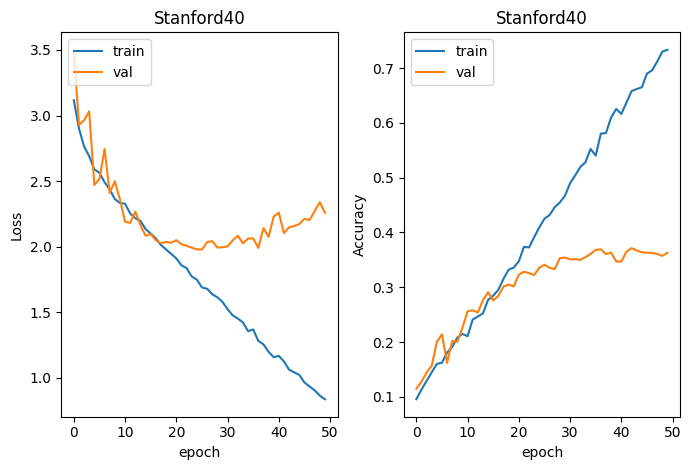

In [7]:
print("STAN40 TRAIN METRICS:\n")
print(stan40_train_perf_metrics)
print("\nSTAN40 TEST METRICS:\n")
print(stan40_test_perf_metrics)
print("\nSTAN40 TRAIN METRICS PLOT:\n")
plot_train_val_metrics(stan40_train_perf_metrics, "Stanford40")

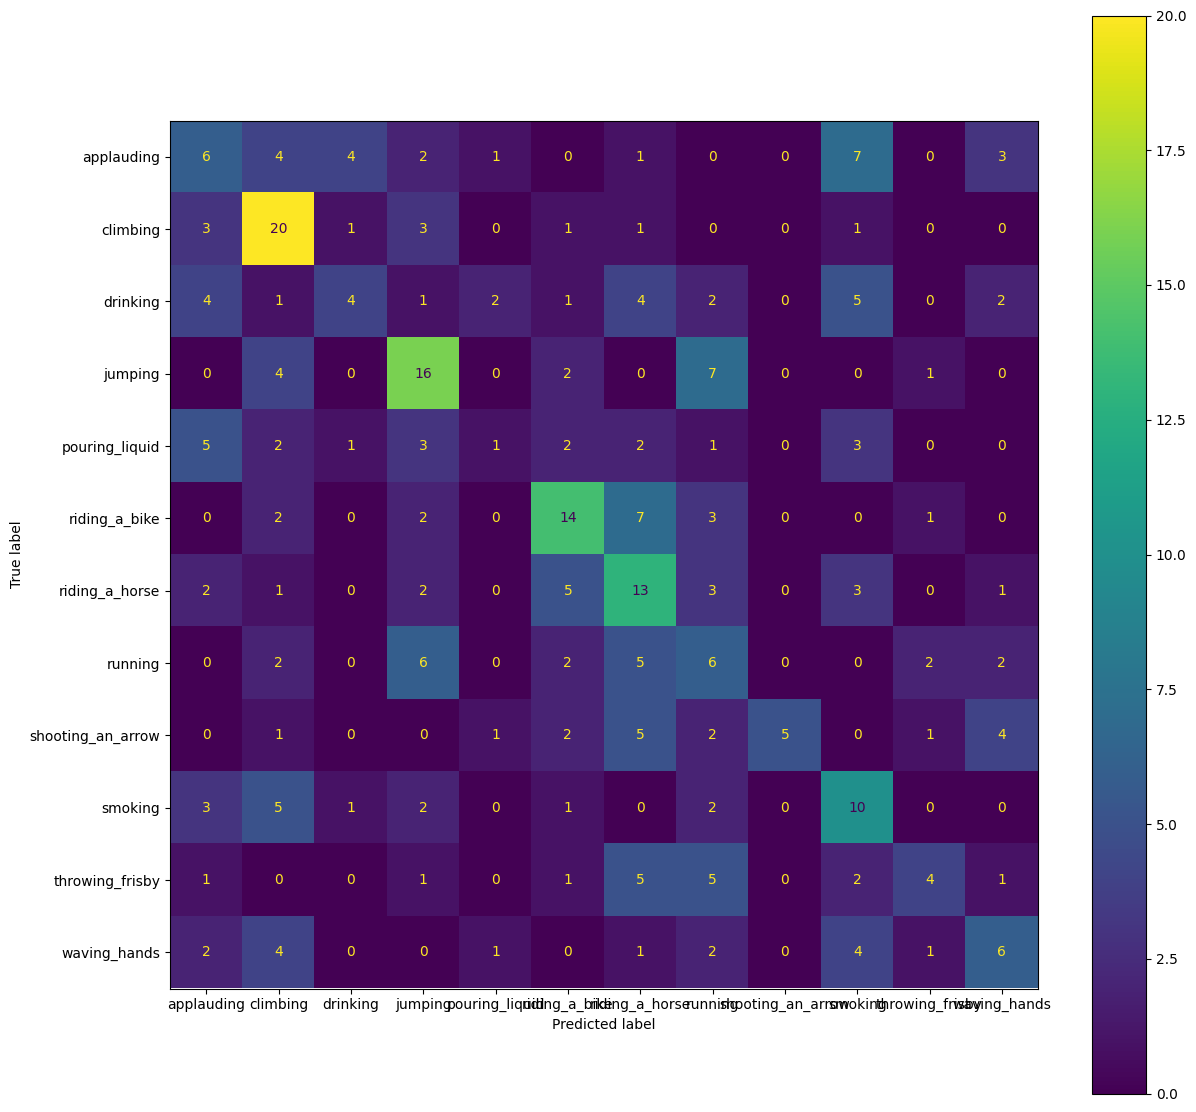

In [8]:
plot_conf_matrix(stan40_X_test, stan40_Y_test, stan40_model, STAN40_CLASSES)

In [9]:
stan40_model.summary()

Model: "Stanford40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 112, 112, 3)       0         
                                                                 
 random_flip_5 (RandomFlip)  (None, 112, 112, 3)       0         
                                                                 
 random_brightness_5 (Random  (None, 112, 112, 3)      0         
 Brightness)                                                     
                                                                 
 random_contrast_5 (RandomCo  (None, 112, 112, 3)      0         
 ntrast)                                                         
                                                                 
 down_1 (Conv2D)             (None, 110, 110, 32)      896       
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 110, 110, 32)      0

In [10]:
serialize_model(stan40_model)

# Task 2

In [11]:
HMDB51_CLASSES = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse", "run", "shoot_bow", "smoke", "throw", "wave"]

! rm -r test_train_splits
! rm -r video_data
! rm -r hmdb51_org.rar
! rm -r test_train_splits.rar

! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar

! mkdir -p video_data test_train_splits
! unrar e test_train_splits.rar test_train_splits
! rm test_train_splits.rar
! unrar e hmdb51_org.rar 
! rm hmdb51_org.rar
! mv *.rar video_data

for class_files in os.listdir('video_data'):
    class_name = class_files.split('.')[0]
    if class_name in HMDB51_CLASSES:
      os.system("mkdir -p " + os.path.join("video_data", class_name))
      os.system("unrar e video_data/"+ class_files + " video_data/"+class_name)

! rm video_data/*.rar

rm: cannot remove 'hmdb51_org.rar': No such file or directory
rm: cannot remove 'test_train_splits.rar': No such file or directory
--2023-04-16 18:11:53--  http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Resolving serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)... 128.148.254.114
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar [following]
--2023-04-16 18:11:54--  https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2124008126 (2.0G)
Saving to: ‘hmdb51_org.rar’

hmdb51_org.rar      100%[===================>]   1.98G   119MB/s    in 17s     

2023-04-16 18:12:11 (117 MB/s) - ‘hmdb51_org.rar’ saved [2

In [12]:
import glob

def get_hmdb51_train_test_lists():
  global HMDB51_CLASSES
  TRAIN_TAG, TEST_TAG = 1, 2
  train_files, test_files = [], []
  train_labels, test_labels = [], []
  split_pattern_name = f"*test_split1.txt"
  split_pattern_path = os.path.join('test_train_splits', split_pattern_name)
  annotation_paths = glob.glob(split_pattern_path)
  for filepath in annotation_paths:
      class_name = '_'.join(filepath.split('/')[-1].split('_')[:-2])
      if class_name not in HMDB51_CLASSES:
          continue
      with open(filepath) as fid:
          lines = fid.readlines()
      for line in lines:
          video_filename, tag_string = line.split()
          tag = int(tag_string)
          if tag == TRAIN_TAG:
              train_files.append(video_filename)
              train_labels.append(HMDB51_CLASSES.index(class_name))
          elif tag == TEST_TAG:
              test_files.append(video_filename)
              test_labels.append(HMDB51_CLASSES.index(class_name))

  train_files, train_labels = shuffle_dataset(np.array(train_files), np.array(train_labels))
  train_files, train_labels = train_files.tolist(), train_labels.tolist()

  test_files, test_labels = shuffle_dataset(np.array(test_files), np.array(test_labels))
  test_files, test_labels = test_files.tolist(), test_labels.tolist()

  return train_files, test_files, train_labels, test_labels

def get_hmdb51_dataset():
  global HMDB51_CLASSES
  
  train_files, test_files, train_labels, test_labels = get_hmdb51_train_test_lists()

  def fill_data(files, labels):
    X_data = np.zeros((len(files), FRAME_SIZE[0], FRAME_SIZE[1], 3))
    for idx, fl in enumerate(zip(files, labels)):
      video = cv2.VideoCapture(os.path.join("video_data", HMDB51_CLASSES[fl[1]], fl[0]))
      halway_frame = int(video.get(cv2.CAP_PROP_FRAME_COUNT)) // 2
      X_data[idx] = get_frames_from_index(video, halway_frame)
    return X_data

  return  fill_data(train_files, train_labels), fill_data(test_files, test_labels), \
          np.array(train_labels, dtype=np.int32), np.array(test_labels, dtype=np.int32)

In [13]:
hmdb51_X_train, hmdb51_X_test, hmdb51_Y_train, hmdb51_Y_test = get_hmdb51_dataset()

In [14]:
def get_tl_hmdb51():
  global FRAME_SIZE
  
  model = tf.keras.models.load_model("Models/Stanford40")
  frozen_layers = ["down_" + str(i) for i in range(1, 9)]

  for i in range(len(model.layers)):
    if model.layers[i].name in frozen_layers:
      model.layers[i].trainable = False

  model._name = "hmdb51tl"
  return model

In [15]:
hmdb51tl_train_perf_metrics = kfold_cv(hmdb51_X_train, hmdb51_Y_train, get_tl_hmdb51, epochs=50, splits=5)
hmdb51tl_model = get_trained_model(hmdb51_X_train, hmdb51_Y_train, get_tl_hmdb51, True, 50)
hmdb51tl_test_perf_metrics = evaluate_model(hmdb51_X_test, hmdb51_Y_test, hmdb51tl_model)

5-Folds Stratified Cross-Validation started
Epoch 1/50
6/6 [==============================] - 3s 104ms/step - loss: 4.3091 - accuracy: 0.2321 - val_loss: 3.3086 - val_accuracy: 0.2976
Epoch 2/50
6/6 [==============================] - 0s 22ms/step - loss: 2.8920 - accuracy: 0.3557 - val_loss: 3.1824 - val_accuracy: 0.3274
Epoch 3/50
6/6 [==============================] - 0s 24ms/step - loss: 2.3339 - accuracy: 0.4211 - val_loss: 3.0495 - val_accuracy: 0.3571
Epoch 4/50
6/6 [==============================] - 0s 22ms/step - loss: 1.9658 - accuracy: 0.4524 - val_loss: 2.8728 - val_accuracy: 0.3929
Epoch 5/50
6/6 [==============================] - 0s 24ms/step - loss: 1.6942 - accuracy: 0.5164 - val_loss: 2.7530 - val_accuracy: 0.3869
Epoch 6/50
6/6 [==============================] - 0s 23ms/step - loss: 1.4504 - accuracy: 0.5759 - val_loss: 2.6409 - val_accuracy: 0.4048
Epoch 7/50
6/6 [==============================] - 0s 23ms/step - loss: 1.2306 - accuracy: 0.6042 - val_loss: 2.5491 - val

HMDB51TL TRAIN METRICS:

{'loss': array([4.2680044 , 2.9320571 , 2.3327813 , 1.9485241 , 1.6510136 ,
       1.441624  , 1.2649674 , 1.1771716 , 1.051766  , 0.98128283,
       0.8911365 , 0.8607632 , 0.7466894 , 0.7343849 , 0.690018  ,
       0.63397896, 0.60852206, 0.5936102 , 0.56574667, 0.5410194 ,
       0.48972625, 0.4865725 , 0.46435627, 0.42454934, 0.427172  ,
       0.40894684, 0.37423438, 0.3710888 , 0.3714225 , 0.3673151 ,
       0.32888338, 0.33449826, 0.3085877 , 0.29518908, 0.2932454 ,
       0.30314812, 0.27245048, 0.28311297, 0.28142264, 0.26004943,
       0.24778835, 0.24523008, 0.27682912, 0.23801462, 0.22663   ,
       0.22604421, 0.22387986, 0.22102773, 0.21923657, 0.20961905],
      dtype=float32), 'accuracy': array([0.22291668, 0.33839288, 0.40892857, 0.4752976 , 0.5190476 ,
       0.5630952 , 0.6053571 , 0.6321429 , 0.6553571 , 0.6755952 ,
       0.70714283, 0.7193452 , 0.76726186, 0.76517856, 0.7747024 ,
       0.7991072 , 0.80952376, 0.8092262 , 0.82410717, 0.832

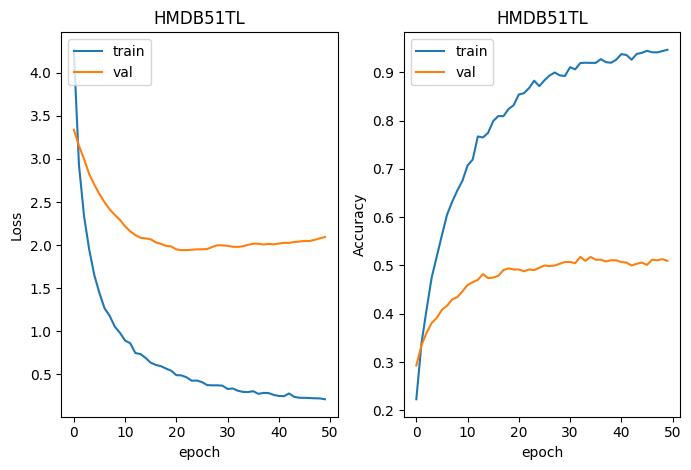

In [16]:
print("HMDB51TL TRAIN METRICS:\n")
print(hmdb51tl_train_perf_metrics)
print("\nHMDB51TL TEST METRICS:\n")
print(hmdb51tl_test_perf_metrics)
print("\nHMDB51TL TRAIN METRICS PLOT:\n")
plot_train_val_metrics(hmdb51tl_train_perf_metrics, "HMDB51TL")

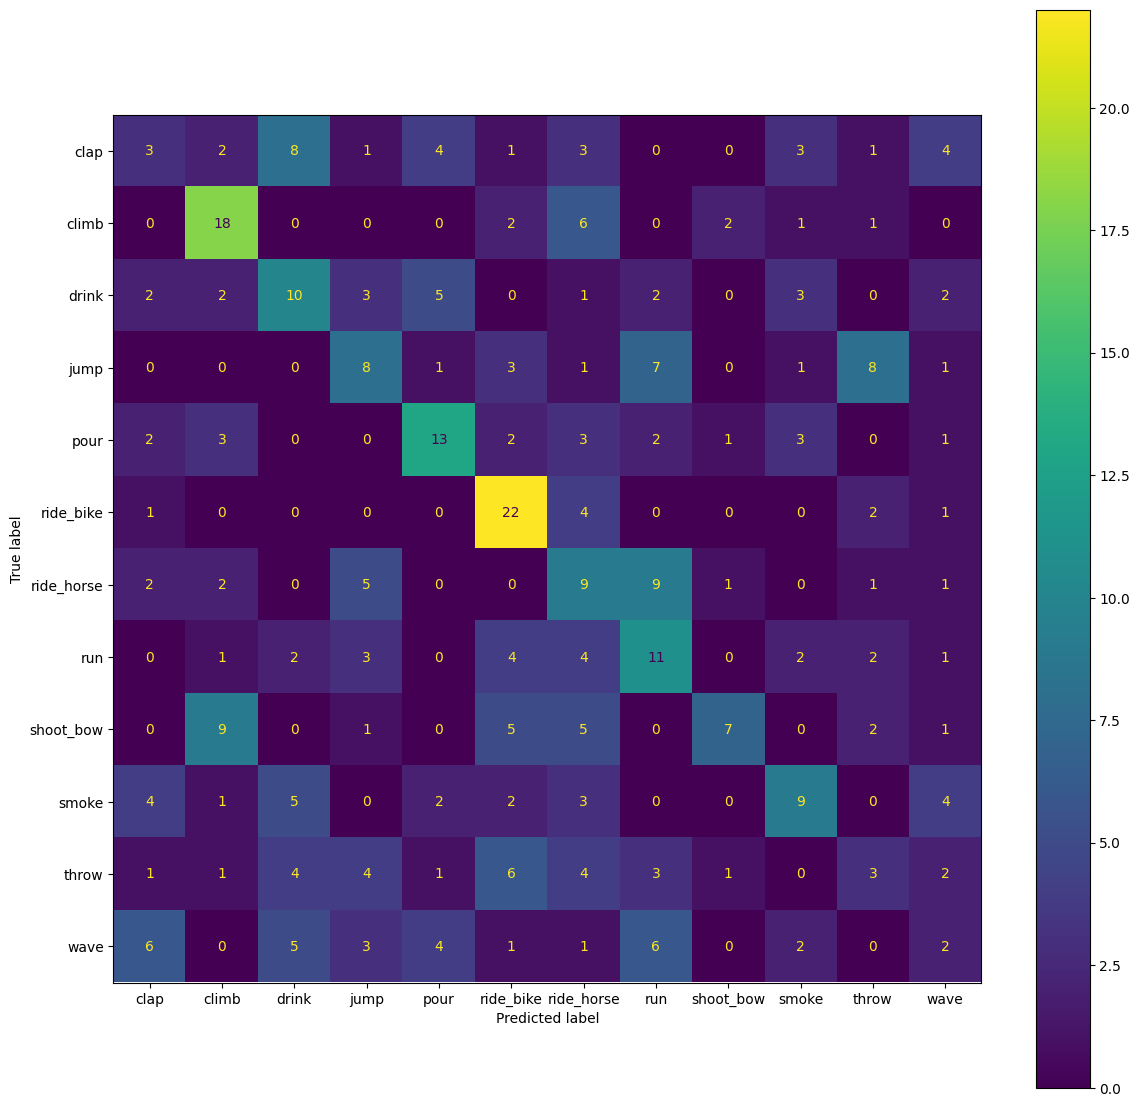

In [17]:
plot_conf_matrix(hmdb51_X_test, hmdb51_Y_test, hmdb51tl_model, HMDB51_CLASSES)

In [18]:
hmdb51tl_model.summary()

Model: "hmdb51tl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 112, 112, 3)       0         
                                                                 
 random_flip_5 (RandomFlip)  (None, 112, 112, 3)       0         
                                                                 
 random_brightness_5 (Random  (None, 112, 112, 3)      0         
 Brightness)                                                     
                                                                 
 random_contrast_5 (RandomCo  (None, 112, 112, 3)      0         
 ntrast)                                                         
                                                                 
 down_1 (Conv2D)             (None, 110, 110, 32)      896       
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 110, 110, 32)      0  

In [19]:
serialize_model(hmdb51tl_model)

# Task 3

In [20]:
STACKED_OF_COUNT = 4

def get_hmdb51_OF_dataset():
  global HMDB51_CLASSES, STACKED_OF_COUNT
  
  train_files, test_files, train_labels, test_labels = get_hmdb51_train_test_lists()

  def fill_data(files, labels):
    X_data = np.zeros((len(files), STACKED_OF_COUNT, FRAME_SIZE[0], FRAME_SIZE[1], 3))
    for idx, fl in enumerate(zip(files, labels)):
      video = cv2.VideoCapture(os.path.join("video_data", HMDB51_CLASSES[fl[1]], fl[0]))
      starting_frame_index = int(video.get(cv2.CAP_PROP_FRAME_COUNT)) // 2 - STACKED_OF_COUNT // 2
      X_data[idx] = compute_optical_flow(video, starting_frame_index)
    return X_data

  return  fill_data(train_files, train_labels), fill_data(test_files, test_labels), \
          np.array(train_labels, dtype=np.int32), np.array(test_labels, dtype=np.int32)

In [21]:
hmdb51_OF_X_train, hmdb51_OF_X_test, hmdb51_OF_Y_train, hmdb51_OF_Y_test = get_hmdb51_OF_dataset()

In [22]:
def get_hmdb51OF():
  global STACKED_OF_COUNT, FRAME_SIZE

  model = tf.keras.Sequential([
    tf.keras.Input(shape=(STACKED_OF_COUNT, FRAME_SIZE[0], FRAME_SIZE[1], 3)),
    tf.keras.layers.Rescaling(1./255),

    tf.keras.layers.Conv2D(32, 3),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(32, 3),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling3D(),

    tf.keras.layers.Conv2D(64, 3),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling3D(),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(12),
    tf.keras.layers.Softmax()
  ])
  model._name = "hmdb51OF"
  return model

In [23]:
hmdb51OF_train_perf_metrics = kfold_cv(hmdb51_OF_X_train, hmdb51_OF_Y_train, get_hmdb51OF, epochs=25, splits=5)
hmdb51OF_model = get_trained_model(hmdb51_OF_X_train, hmdb51_OF_Y_train, get_hmdb51OF)
hmdb51OF_test_perf_metrics = evaluate_model(hmdb51_OF_X_test, hmdb51_OF_Y_test, hmdb51OF_model)

5-Folds Stratified Cross-Validation started
Epoch 1/25
6/6 [==============================] - 9s 564ms/step - loss: 3.0225 - accuracy: 0.1250 - val_loss: 2.6772 - val_accuracy: 0.1250
Epoch 2/25
6/6 [==============================] - 1s 99ms/step - loss: 2.5226 - accuracy: 0.1935 - val_loss: 2.5403 - val_accuracy: 0.1548
Epoch 3/25
6/6 [==============================] - 1s 102ms/step - loss: 2.2735 - accuracy: 0.2842 - val_loss: 2.3455 - val_accuracy: 0.2024
Epoch 4/25
6/6 [==============================] - 1s 96ms/step - loss: 2.2339 - accuracy: 0.2976 - val_loss: 2.2891 - val_accuracy: 0.2202
Epoch 5/25
6/6 [==============================] - 1s 100ms/step - loss: 2.0060 - accuracy: 0.3333 - val_loss: 2.2766 - val_accuracy: 0.2083
Epoch 6/25
6/6 [==============================] - 1s 96ms/step - loss: 1.9183 - accuracy: 0.3854 - val_loss: 2.4129 - val_accuracy: 0.1726
Epoch 7/25
6/6 [==============================] - 1s 100ms/step - loss: 1.8333 - accuracy: 0.3973 - val_loss: 2.2278 - 

HMDB51OF TRAIN METRICS:

{'loss': array([2.9315841 , 2.5099335 , 2.282809  , 2.1754696 , 2.0295143 ,
       1.8812546 , 1.7944962 , 1.5828407 , 1.3927901 , 1.2597954 ,
       1.0833316 , 0.9445484 , 0.80838585, 0.6870384 , 0.5908411 ,
       0.5130952 , 0.44180474, 0.39041558, 0.3556048 , 0.3125357 ,
       0.28885764, 0.2561201 , 0.24269149, 0.22557291, 0.21573727],
      dtype=float32), 'accuracy': array([0.14255953, 0.20625   , 0.26964283, 0.29107141, 0.33869046,
       0.40357143, 0.41875   , 0.49672619, 0.55476195, 0.6133929 ,
       0.6642858 , 0.73184526, 0.7794643 , 0.8166667 , 0.8630953 ,
       0.88779765, 0.90476197, 0.92023814, 0.93125   , 0.94375   ,
       0.94375   , 0.9550595 , 0.95238096, 0.9529762 , 0.9577381 ],
      dtype=float32), 'val_loss': array([3.8018448, 3.7753582, 2.921392 , 2.6335533, 2.6418347, 2.6753824,
       2.2977834, 2.2343478, 2.1743512, 2.2226417, 2.2929301, 2.281252 ,
       2.3591247, 2.3418012, 2.3834398, 2.389764 , 2.4491086, 2.427317 ,
       

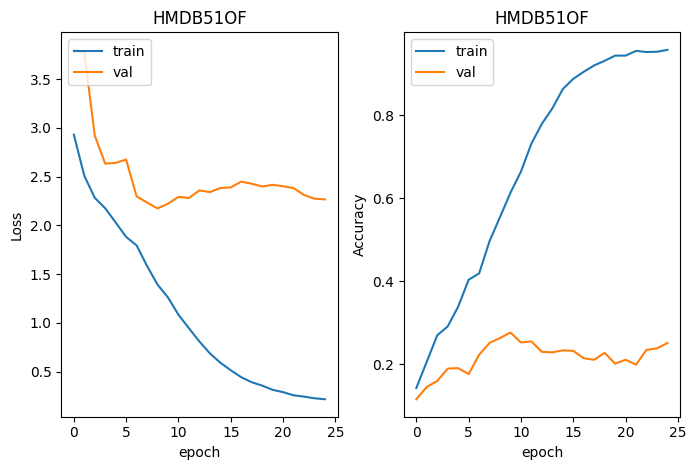

In [24]:
print("HMDB51OF TRAIN METRICS:\n")
print(hmdb51OF_train_perf_metrics)
print("\nHMDB51OF TEST METRICS:\n")
print(hmdb51OF_test_perf_metrics)
print("\nHMDB51OF TRAIN METRICS PLOT:\n")
plot_train_val_metrics(hmdb51OF_train_perf_metrics, "HMDB51OF")

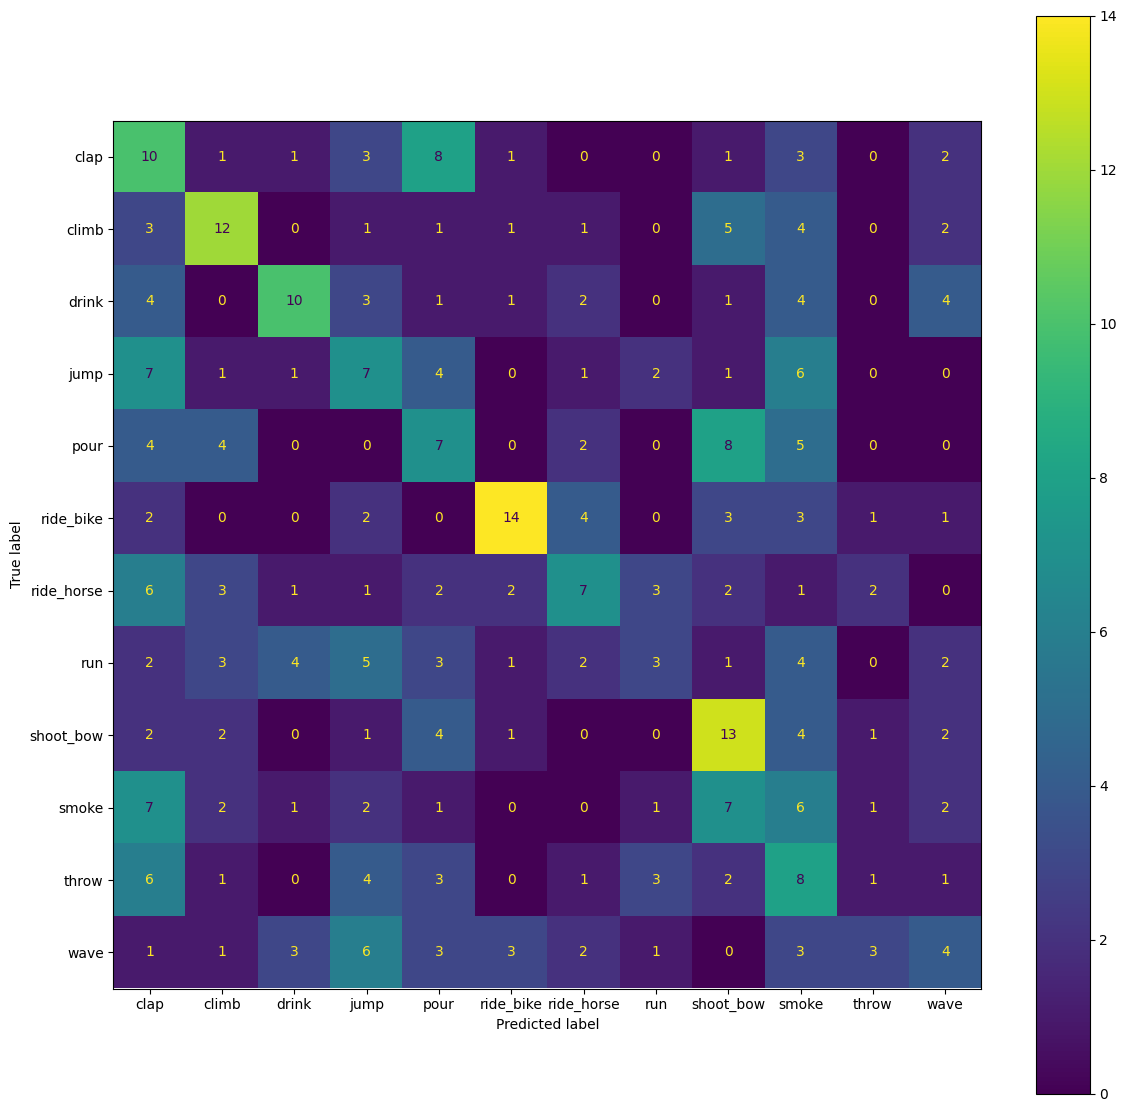

In [25]:
plot_conf_matrix(hmdb51_OF_X_test, hmdb51_OF_Y_test, hmdb51OF_model, HMDB51_CLASSES)

In [26]:
hmdb51OF_model.summary()

Model: "hmdb51OF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 4, 112, 112, 3)    0         
                                                                 
 conv2d_20 (Conv2D)          (None, 4, 110, 110, 32)   896       
                                                                 
 leaky_re_lu_66 (LeakyReLU)  (None, 4, 110, 110, 32)   0         
                                                                 
 conv2d_21 (Conv2D)          (None, 4, 108, 108, 32)   9248      
                                                                 
 leaky_re_lu_67 (LeakyReLU)  (None, 4, 108, 108, 32)   0         
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 2, 54, 54, 32)    0         
 g3D)                                                            
                                                          

In [27]:
serialize_model(hmdb51OF_model)

# Task 4

In [28]:
def get_hmdb51_OF_MXD_dataset():
  global HMDB51_CLASSES, STACKED_OF_COUNT
  
  train_files, test_files, train_labels, test_labels = get_hmdb51_train_test_lists()

  def fill_data(files, labels):
    X_OF_data = np.zeros((len(files), STACKED_OF_COUNT, FRAME_SIZE[0], FRAME_SIZE[1], 3))
    X_data = np.zeros((len(files), FRAME_SIZE[0], FRAME_SIZE[1], 3))
    
    for idx, fl in enumerate(zip(files, labels)):
      video = cv2.VideoCapture(os.path.join("video_data", HMDB51_CLASSES[fl[1]], fl[0]))
      starting_frame_index = int(video.get(cv2.CAP_PROP_FRAME_COUNT)) // 2 - STACKED_OF_COUNT // 2
      X_OF_data[idx] = compute_optical_flow(video, starting_frame_index)
      video.release()
      video = cv2.VideoCapture(os.path.join("video_data", HMDB51_CLASSES[fl[1]], fl[0]))
      X_data[idx] = get_frames_from_index(video, starting_frame_index)
      video.release()
    return (X_OF_data, X_data)

  return  fill_data(train_files, train_labels), fill_data(test_files, test_labels), \
          np.array(train_labels, dtype=np.int32), np.array(test_labels, dtype=np.int32)

In [29]:
hmdb51_OF_MXD_X_train, hmdb51_OF_MXD_X_test, hmdb51_OF_MXD_Y_train, hmdb51_OF_MXD_Y_test = get_hmdb51_OF_MXD_dataset()

In [30]:
def get_hmdb51MXD(merge_layer=None):
  global STACKED_OF_COUNT, FRAME_SIZE

  plain_input_model = tf.keras.models.load_model("Models/hmdb51tl")
  OF_model = tf.keras.models.load_model("Models/hmdb51OF")

  plain_input_model.trainable = False
  OF_model.trainable = False

  if merge_layer is None:
    merge_layer = tf.keras.layers.concatenate([OF_model.layers[-2].output, 
                                               plain_input_model.layers[-2].output])
  else:
    merge_layer = merge_layer()([OF_model.layers[-2].output, 
                                 plain_input_model.layers[-2].output])

  x = tf.keras.layers.ReLU(name="shared_4")(merge_layer)
  x = tf.keras.layers.Dense(16, name="shared_5")(x)
  x = tf.keras.layers.BatchNormalization(name="shared_6")(x)
  x = tf.keras.layers.ReLU(name="shared_7")(x)

  x = tf.keras.layers.Dense(12, activation="softmax", name="shared_9")(x)

  model = tf.keras.Model(inputs=[OF_model.input, plain_input_model.input], outputs=x)

  model._name = "hmdb51MXD"
  return model

In [31]:
hmdb51MXD_train_perf_metrics = multi_input_kfold_cv(hmdb51_OF_MXD_X_train, hmdb51_OF_MXD_Y_train, get_hmdb51MXD, epochs=25, splits=5)
hmdb51MXD_model = get_trained_model(hmdb51_OF_MXD_X_train, hmdb51_OF_MXD_Y_train, get_hmdb51MXD)
hmdb51MXD_test_perf_metrics = evaluate_model(hmdb51_OF_MXD_X_test, hmdb51_OF_MXD_Y_test, hmdb51MXD_model)

Epoch 1/25
6/6 [==============================] - 3s 179ms/step - loss: 2.6622 - accuracy: 0.1369 - val_loss: 3.4084 - val_accuracy: 0.1369
Epoch 2/25
6/6 [==============================] - 0s 67ms/step - loss: 2.5444 - accuracy: 0.1801 - val_loss: 3.0108 - val_accuracy: 0.1667
Epoch 3/25
6/6 [==============================] - 0s 66ms/step - loss: 2.4838 - accuracy: 0.1905 - val_loss: 2.7212 - val_accuracy: 0.1726
Epoch 4/25
6/6 [==============================] - 0s 69ms/step - loss: 2.4052 - accuracy: 0.2113 - val_loss: 2.5197 - val_accuracy: 0.2143
Epoch 5/25
6/6 [==============================] - 0s 66ms/step - loss: 2.3511 - accuracy: 0.2202 - val_loss: 2.3540 - val_accuracy: 0.2262
Epoch 6/25
6/6 [==============================] - 0s 65ms/step - loss: 2.2710 - accuracy: 0.2321 - val_loss: 2.2119 - val_accuracy: 0.2381
Epoch 7/25
6/6 [==============================] - 0s 66ms/step - loss: 2.2325 - accuracy: 0.2812 - val_loss: 2.0957 - val_accuracy: 0.2500
Epoch 8/25
6/6 [==========

HMDB51MXD TRAIN METRICS:

{'loss': array([2.6721578, 2.5867946, 2.5033677, 2.4449801, 2.368573 , 2.2956986,
       2.2358265, 2.1562667, 2.0937812, 2.030278 , 1.9612023, 1.908242 ,
       1.8397497, 1.7931359, 1.7460454, 1.6845413, 1.6126096, 1.5705448,
       1.5304195, 1.467525 , 1.4307578, 1.3714947, 1.324894 , 1.2911735,
       1.2201207], dtype=float32), 'accuracy': array([0.08511905, 0.10803572, 0.12142857, 0.14940476, 0.16785714,
       0.19285715, 0.22916666, 0.2669643 , 0.29732144, 0.34910715,
       0.3842262 , 0.43392855, 0.47589284, 0.51339287, 0.5434524 ,
       0.5910714 , 0.6282738 , 0.6592262 , 0.68511903, 0.72321427,
       0.7431547 , 0.77767855, 0.79761904, 0.8133928 , 0.83988094],
      dtype=float32), 'val_loss': array([3.6549606, 3.1967933, 2.87527  , 2.6419342, 2.4508471, 2.2875454,
       2.1538138, 2.036386 , 1.9299037, 1.83372  , 1.7447665, 1.6624653,
       1.5808246, 1.5085094, 1.4381659, 1.377887 , 1.3112787, 1.2512602,
       1.1933272, 1.1328675, 1.083645

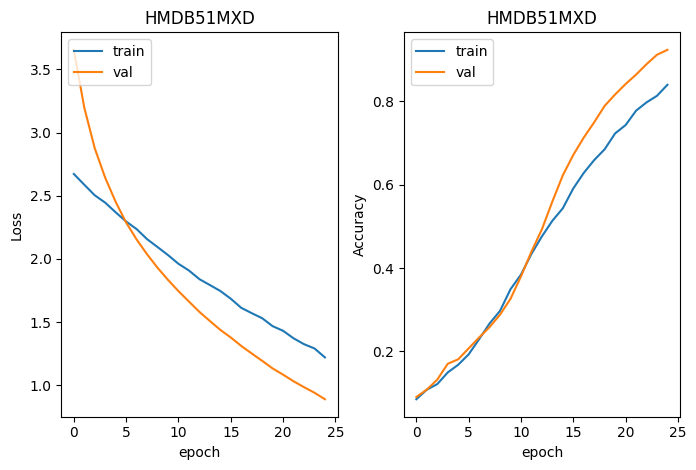

In [32]:
print("HMDB51MXD TRAIN METRICS:\n")
print(hmdb51MXD_train_perf_metrics)
print("\nHMDB51MXD TEST METRICS:\n")
print(hmdb51MXD_test_perf_metrics)
print("\nHMDB51MXD TRAIN METRICS PLOT:\n")
plot_train_val_metrics(hmdb51MXD_train_perf_metrics, "HMDB51MXD")

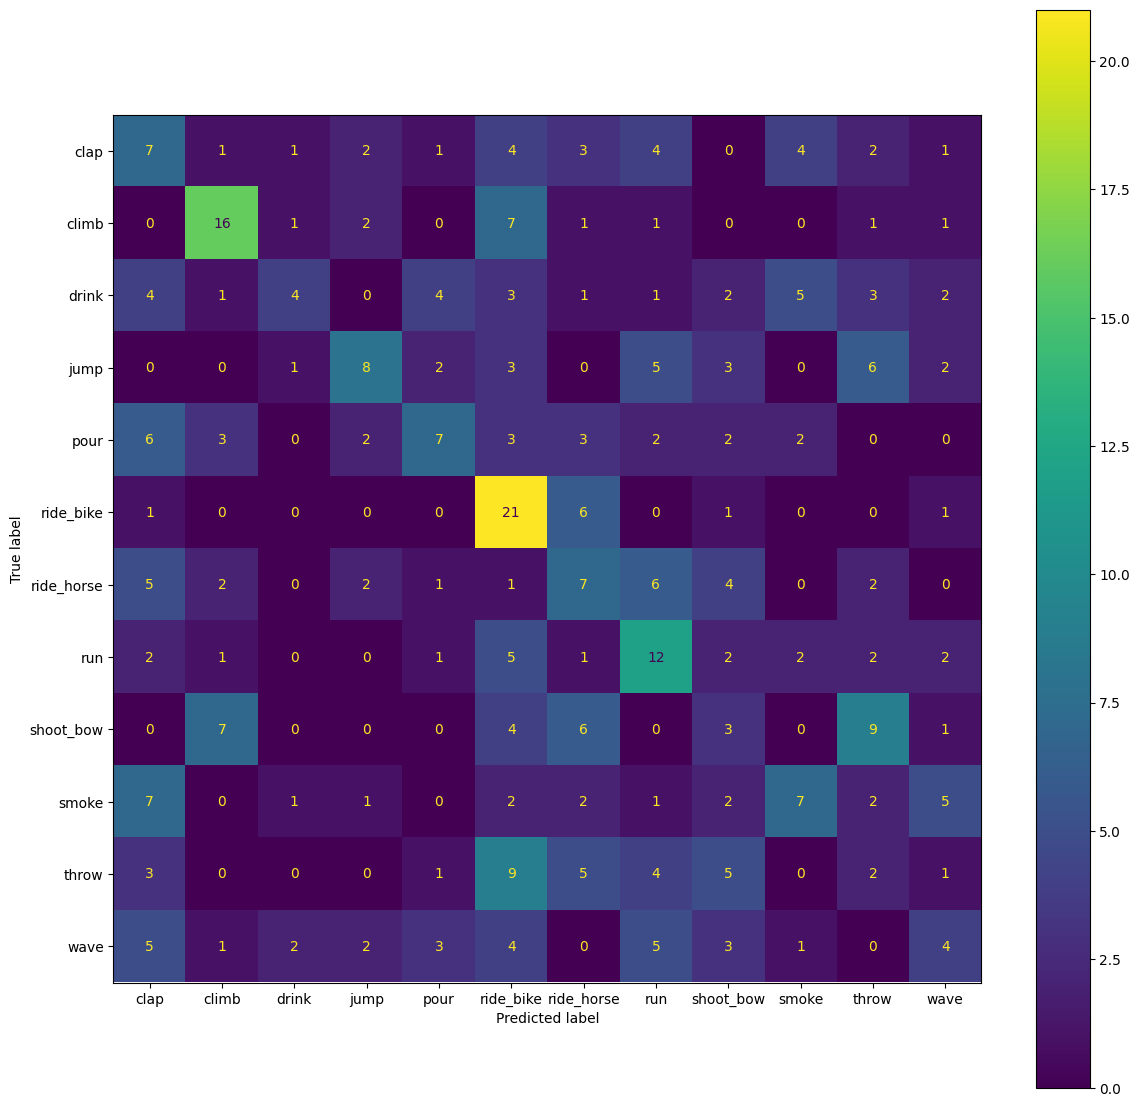

In [33]:
plot_conf_matrix(hmdb51_OF_MXD_X_test, hmdb51_OF_MXD_Y_test, hmdb51MXD_model, HMDB51_CLASSES)

In [34]:
hmdb51MXD_model.summary()

Model: "hmdb51MXD"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 112, 112, 3)  0           ['input_6[0][0]']                
                                                                                                  
 random_flip_5 (RandomFlip)     (None, 112, 112, 3)  0           ['rescaling_5[0][0]']            
                                                                                                  
 random_brightness_5 (RandomBri  (None, 112, 112, 3)  0          ['random_flip_5[0][0]']  

In [35]:
serialize_model(hmdb51MXD_model)

Epoch 1/25
6/6 [==============================] - 3s 176ms/step - loss: 2.6193 - accuracy: 0.0238 - val_loss: 2.9756 - val_accuracy: 0.0060
Epoch 2/25
6/6 [==============================] - 0s 67ms/step - loss: 2.5531 - accuracy: 0.0685 - val_loss: 2.7459 - val_accuracy: 0.0119
Epoch 3/25
6/6 [==============================] - 0s 67ms/step - loss: 2.4809 - accuracy: 0.0729 - val_loss: 2.5685 - val_accuracy: 0.0238
Epoch 4/25
6/6 [==============================] - 0s 65ms/step - loss: 2.4178 - accuracy: 0.1339 - val_loss: 2.4266 - val_accuracy: 0.0417
Epoch 5/25
6/6 [==============================] - 0s 65ms/step - loss: 2.3464 - accuracy: 0.1592 - val_loss: 2.3007 - val_accuracy: 0.1190
Epoch 6/25
6/6 [==============================] - 0s 65ms/step - loss: 2.2805 - accuracy: 0.2277 - val_loss: 2.1882 - val_accuracy: 0.2083
Epoch 7/25
6/6 [==============================] - 0s 68ms/step - loss: 2.2265 - accuracy: 0.2634 - val_loss: 2.0908 - val_accuracy: 0.2619
Epoch 8/25
6/6 [==========

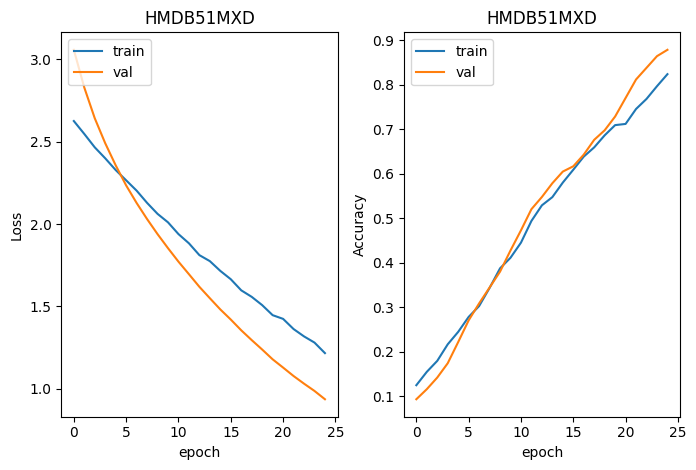

Epoch 1/25
6/6 [==============================] - 3s 176ms/step - loss: 2.7326 - accuracy: 0.0164 - val_loss: 3.8167 - val_accuracy: 0.0714
Epoch 2/25
6/6 [==============================] - 0s 67ms/step - loss: 2.6995 - accuracy: 0.0253 - val_loss: 3.3581 - val_accuracy: 0.0833
Epoch 3/25
6/6 [==============================] - 0s 65ms/step - loss: 2.6190 - accuracy: 0.0417 - val_loss: 3.0449 - val_accuracy: 0.0893
Epoch 4/25
6/6 [==============================] - 0s 65ms/step - loss: 2.5608 - accuracy: 0.0446 - val_loss: 2.8318 - val_accuracy: 0.1012
Epoch 5/25
6/6 [==============================] - 0s 68ms/step - loss: 2.5022 - accuracy: 0.0536 - val_loss: 2.6508 - val_accuracy: 0.1012
Epoch 6/25
6/6 [==============================] - 0s 69ms/step - loss: 2.4522 - accuracy: 0.0818 - val_loss: 2.4956 - val_accuracy: 0.1131
Epoch 7/25
6/6 [==============================] - 0s 67ms/step - loss: 2.3860 - accuracy: 0.0982 - val_loss: 2.3720 - val_accuracy: 0.1131
Epoch 8/25
6/6 [==========

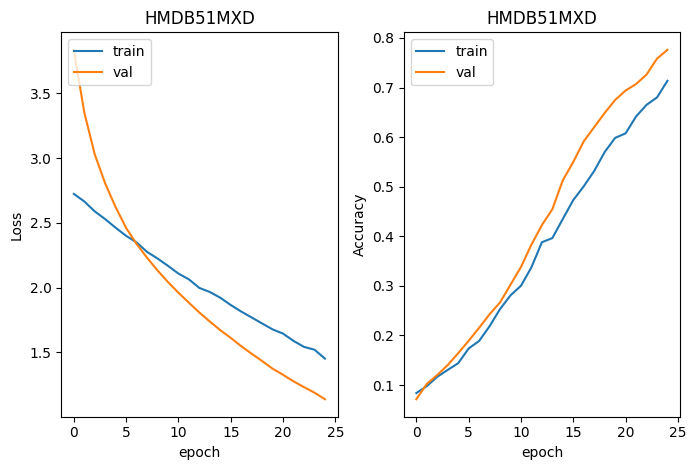

Epoch 1/25
6/6 [==============================] - 3s 175ms/step - loss: 2.6818 - accuracy: 0.1042 - val_loss: 3.7727 - val_accuracy: 0.0119
Epoch 2/25
6/6 [==============================] - 0s 65ms/step - loss: 2.5987 - accuracy: 0.1146 - val_loss: 3.2180 - val_accuracy: 0.0119
Epoch 3/25
6/6 [==============================] - 0s 66ms/step - loss: 2.5344 - accuracy: 0.1324 - val_loss: 2.8785 - val_accuracy: 0.0536
Epoch 4/25
6/6 [==============================] - 0s 67ms/step - loss: 2.4505 - accuracy: 0.1354 - val_loss: 2.6460 - val_accuracy: 0.1131
Epoch 5/25
6/6 [==============================] - 0s 65ms/step - loss: 2.3667 - accuracy: 0.1533 - val_loss: 2.4641 - val_accuracy: 0.1786
Epoch 6/25
6/6 [==============================] - 0s 66ms/step - loss: 2.2972 - accuracy: 0.1801 - val_loss: 2.3107 - val_accuracy: 0.2381
Epoch 7/25
6/6 [==============================] - 0s 66ms/step - loss: 2.2503 - accuracy: 0.2054 - val_loss: 2.1850 - val_accuracy: 0.2560
Epoch 8/25
6/6 [==========

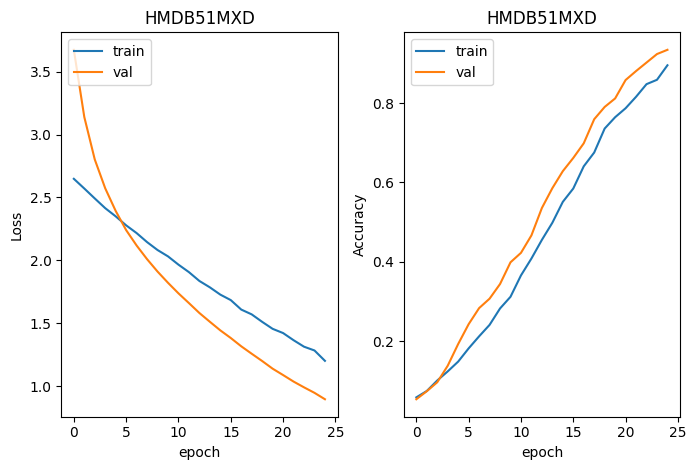

In [36]:
additional_merge_layers = [tf.keras.layers.Average, tf.keras.layers.Maximum, tf.keras.layers.Add]

for merge_layer in additional_merge_layers:
  hmdb51MXD_train_perf_metrics = multi_input_kfold_cv(hmdb51_OF_MXD_X_train, hmdb51_OF_MXD_Y_train, \
                                                      lambda: get_hmdb51MXD(merge_layer), epochs=25, splits=5)
  hmdb51MXD_model = get_trained_model(hmdb51_OF_MXD_X_train, hmdb51_OF_MXD_Y_train, get_hmdb51MXD)
  hmdb51MXD_test_perf_metrics = evaluate_model(hmdb51_OF_MXD_X_test, hmdb51_OF_MXD_Y_test, hmdb51MXD_model)

  print("HMDB51MXD TRAIN METRICS:\n")
  print(hmdb51MXD_train_perf_metrics)
  print("\nHMDB51MXD TEST METRICS:\n")
  print(hmdb51MXD_test_perf_metrics)
  print("\nHMDB51MXD TRAIN METRICS PLOT:\n")
  plot_train_val_metrics(hmdb51MXD_train_perf_metrics, "HMDB51MXD")

In [37]:
!zip "Models.zip" "Models"

from google.colab import files
files.download("Models.zip")

  adding: Models/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>